In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import statsmodels
from collections import Counter
import cpi
import ast
import json
import datetime
from sklearn.decomposition import PCA
from collections import Counter

In [2]:
# Source: https://stackoverflow.com/questions/43214978/seaborn-barplot-displaying-values
def show_values_on_bars(axs, h_v="v", space=0.4):
    def _show_on_single_plot(ax):
        if h_v == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height()
                value = int(p.get_height())
                ax.text(_x, _y, value, ha="center") 
        elif h_v == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height()
                value = int(p.get_width())
                ax.text(_x, _y, value, ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

In [3]:
dataset_original = pd.read_csv('./tmdb-box-office-prediction/train.csv')
dataset_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     3000 non-null   int64  
 1   belongs_to_collection  604 non-null    object 
 2   budget                 3000 non-null   int64  
 3   genres                 2993 non-null   object 
 4   homepage               946 non-null    object 
 5   imdb_id                3000 non-null   object 
 6   original_language      3000 non-null   object 
 7   original_title         3000 non-null   object 
 8   overview               2992 non-null   object 
 9   popularity             3000 non-null   float64
 10  poster_path            2999 non-null   object 
 11  production_companies   2844 non-null   object 
 12  production_countries   2945 non-null   object 
 13  release_date           3000 non-null   object 
 14  runtime                2998 non-null   float64
 15  spok

In [4]:
dataset = dataset_original.copy()

def fix_date(date):
    x = pd.to_datetime(date, format="%m/%d/%y")
    if x.year > 2020:
        year = x.year - 100
    else:
        year = x.year
    return datetime.datetime(year,x.month,x.day)

dataset["release_date"] = dataset_original["release_date"].apply(fix_date)

def adjust_price_to_inflation(price, date):
    return int(cpi.inflate(price, date.year))

dataset["budget"] = dataset.apply(lambda x: adjust_price_to_inflation(x["budget"], x["release_date"]), axis=1)
dataset["revenue"] = dataset.apply(lambda x: adjust_price_to_inflation(x["revenue"], x["release_date"]), axis=1)

In [5]:
print("Oldest: ", dataset["release_date"].min())
print("Newest: ", dataset["release_date"].max())

Oldest:  1921-01-21 00:00:00
Newest:  2017-07-20 00:00:00


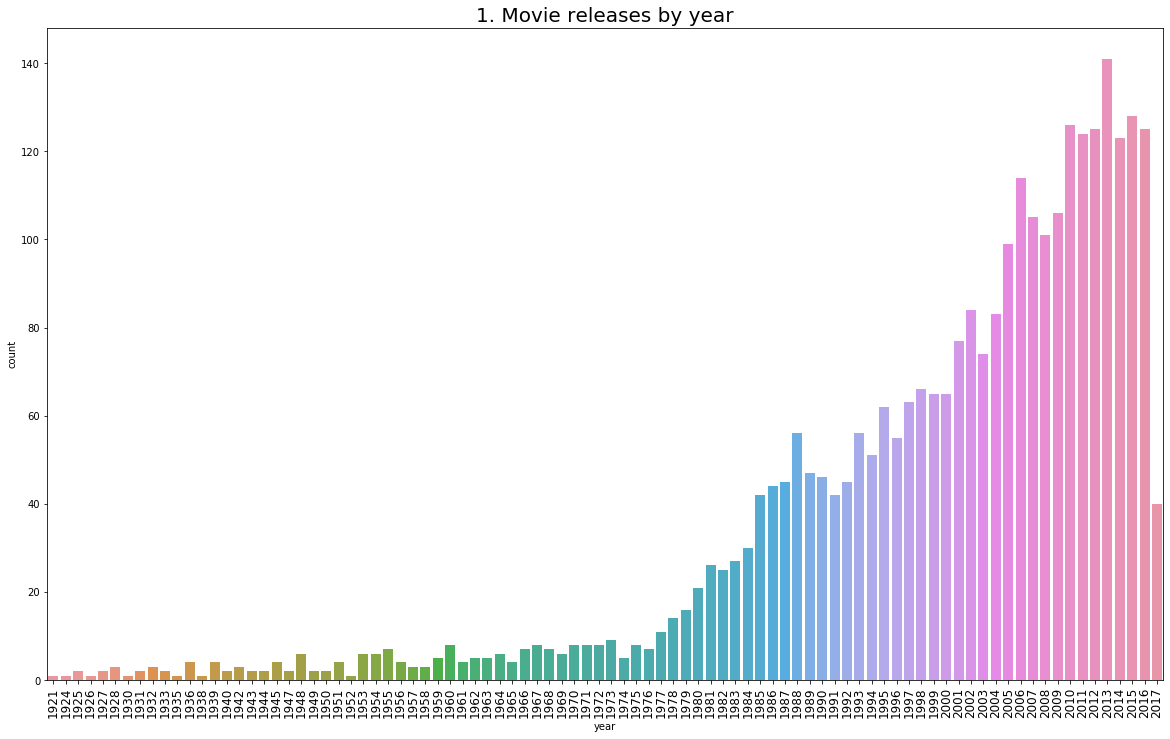

In [6]:
plt.figure(figsize=(20,12))
sns.countplot(dataset['release_date'].dt.year.sort_values())
plt.title("1. Movie releases by year",fontsize=20)
plt.xticks(fontsize=12,rotation=90)
plt.xlabel("year")
plt.show()

Nasz zbiór danych posiada więcej filmów z lat współczesnych

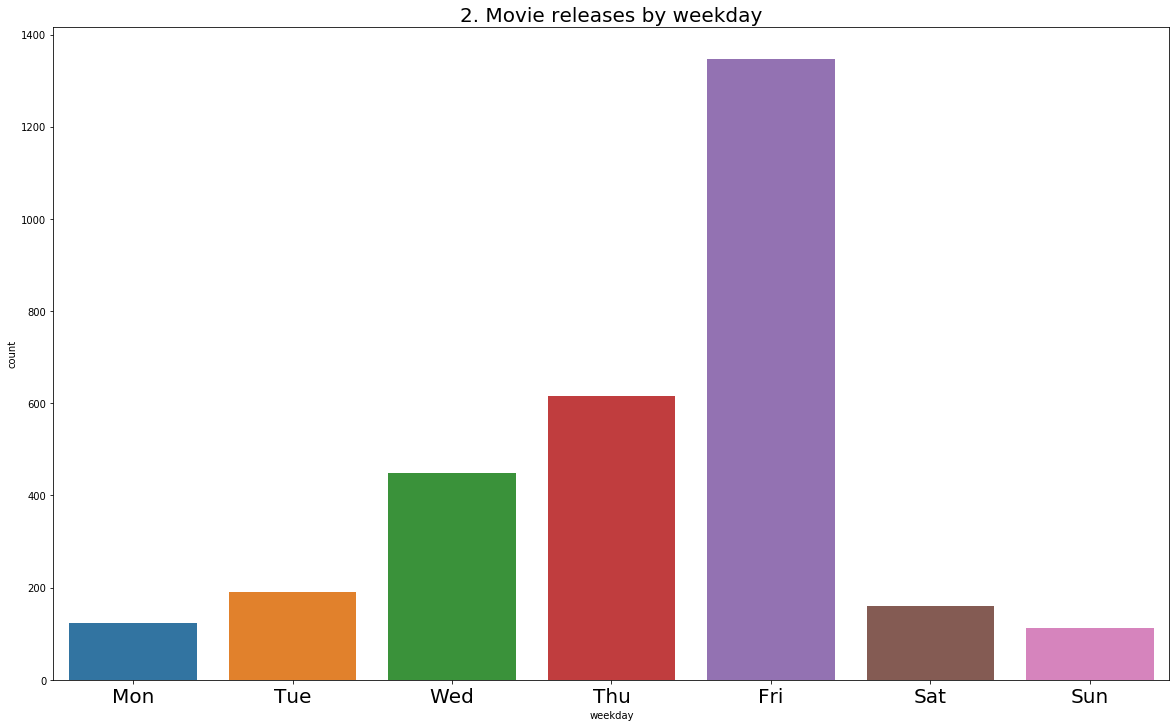

In [7]:
plt.figure(figsize=(20,12))
sns.countplot(dataset['release_date'].dt.weekday.sort_values())
plt.title("2. Movie releases by weekday",fontsize=20)
loc, _ = plt.xticks()
loc, labels = loc, ["Mon","Tue","Wed","Thu","Fri","Sat","Sun"]
plt.xticks(loc, labels,fontsize=20)
plt.xlabel("weekday")
plt.show()

Najwięcej filmów wydaje się w dni przed weekendem - środę, czwartek i piątek, najmniej natomiast w poniedziałek, wtorek, sobotę i niedzielę

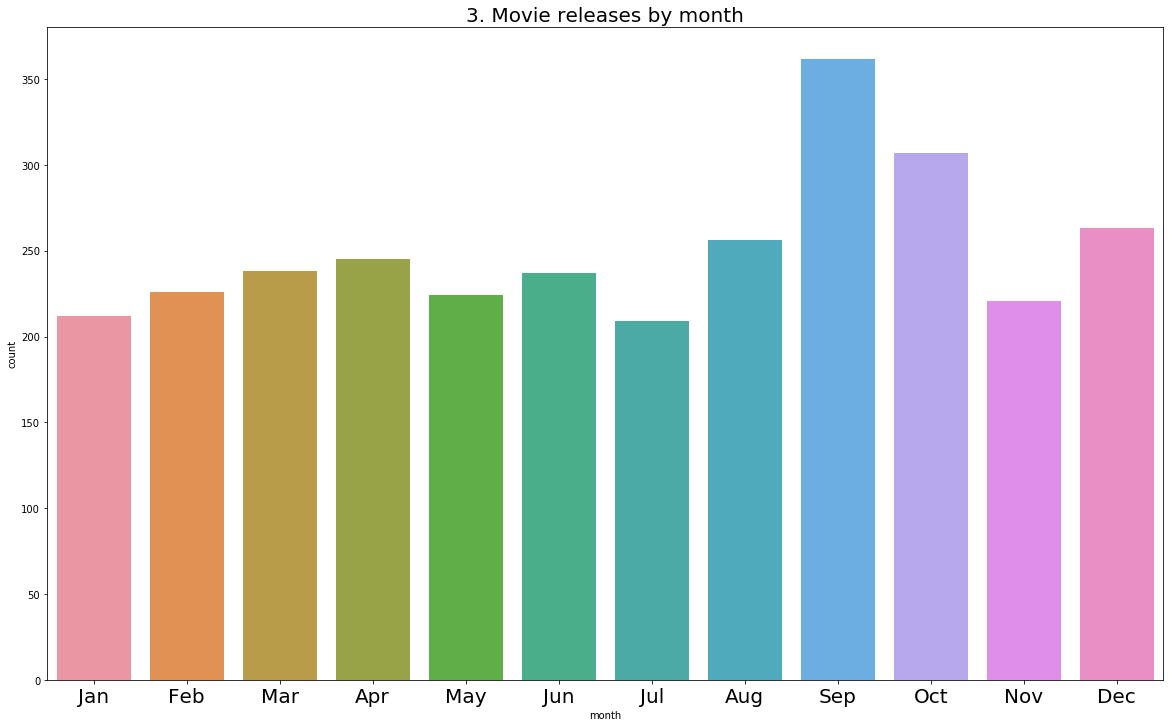

In [8]:
plt.figure(figsize=(20,12))
sns.countplot(dataset['release_date'].dt.month.sort_values())
plt.title("3. Movie releases by month",fontsize=20)
loc, _ = plt.xticks()
loc, labels = loc, ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
plt.xticks(loc, labels,fontsize=20)
plt.xlabel("month")
plt.show()

Ilość filmów wydawanych w ciągu roku jest podobna, najwięcej filmów zostało wydanych we wrześniu a najmniej w lipcu

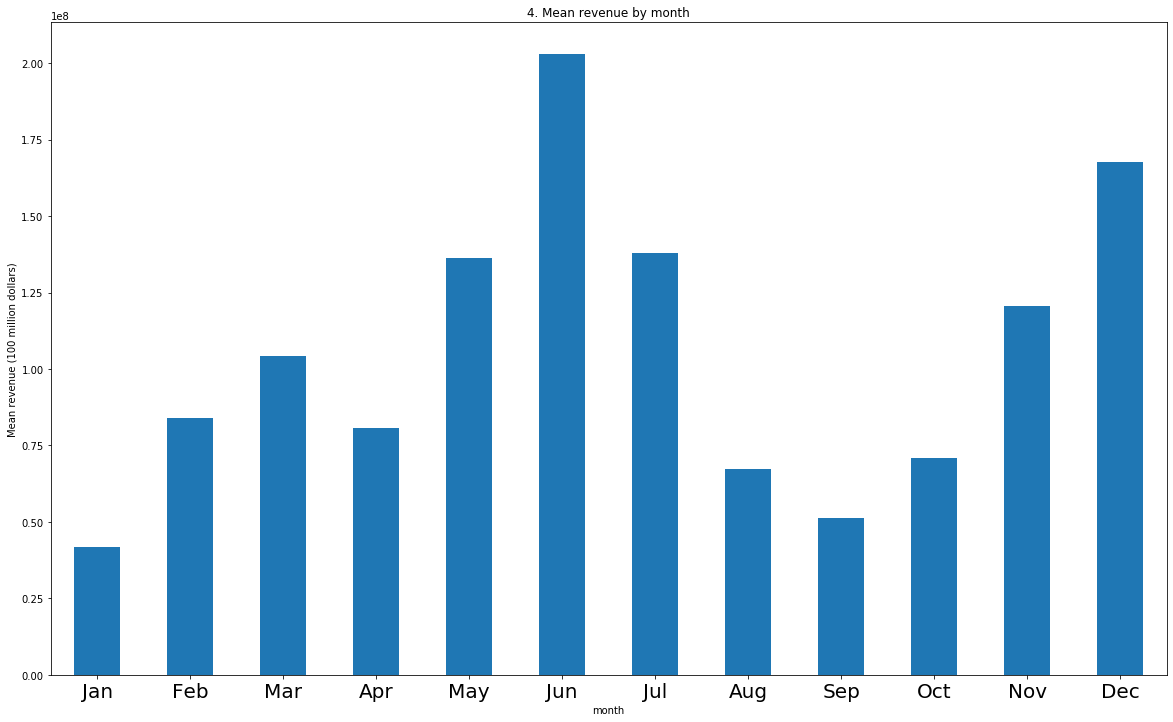

In [9]:
plt.figure(figsize=(20,12))
dataset.groupby(dataset["release_date"].dt.month).agg('mean')['revenue'].plot(kind='bar',rot=0)
plt.ylabel('Mean revenue (100 million dollars)')
plt.title("4. Mean revenue by month")
loc, _ = plt.xticks()
loc, labels = loc, ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
plt.xticks(loc, labels,fontsize=20)
plt.xlabel("month")
plt.show()

Średnio najwięcej przychodów przynoszą filmy wydane w czerwcu a najmniej filmy wydane w styczniu

In [10]:
import ast
dict_columns = ['belongs_to_collection', 'genres', 'production_companies',
                'production_countries', 'spoken_languages', 'Keywords', 'cast', 'crew']

def text_to_dict(df):
    for column in dict_columns:
        df[column] = df[column].apply(lambda x: {} if pd.isna(x) else ast.literal_eval(x) )
    return df
 
dataset = text_to_dict(dataset)

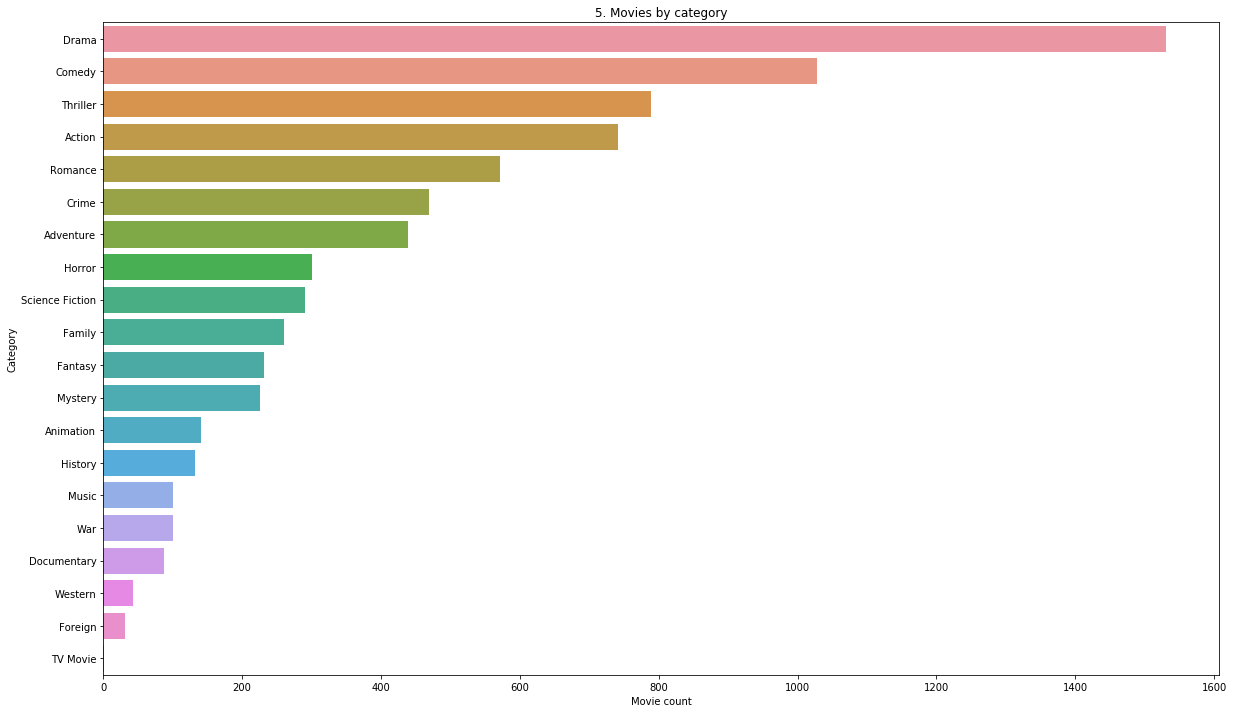

In [11]:
plt.figure(figsize=(20,12))
genre=dataset['genres'].apply(lambda x: [i['name'] for i in x] if x != {} else [])
count=Counter([i for j in genre for i in j]).most_common(20)
sns.barplot([val[1] for val in count],[val[0] for val in count])
plt.title("5. Movies by category")
plt.xlabel("Movie count")
plt.ylabel("Category")
plt.show()

Najwięcej wydanych zostało dramatów a najmniej westernów

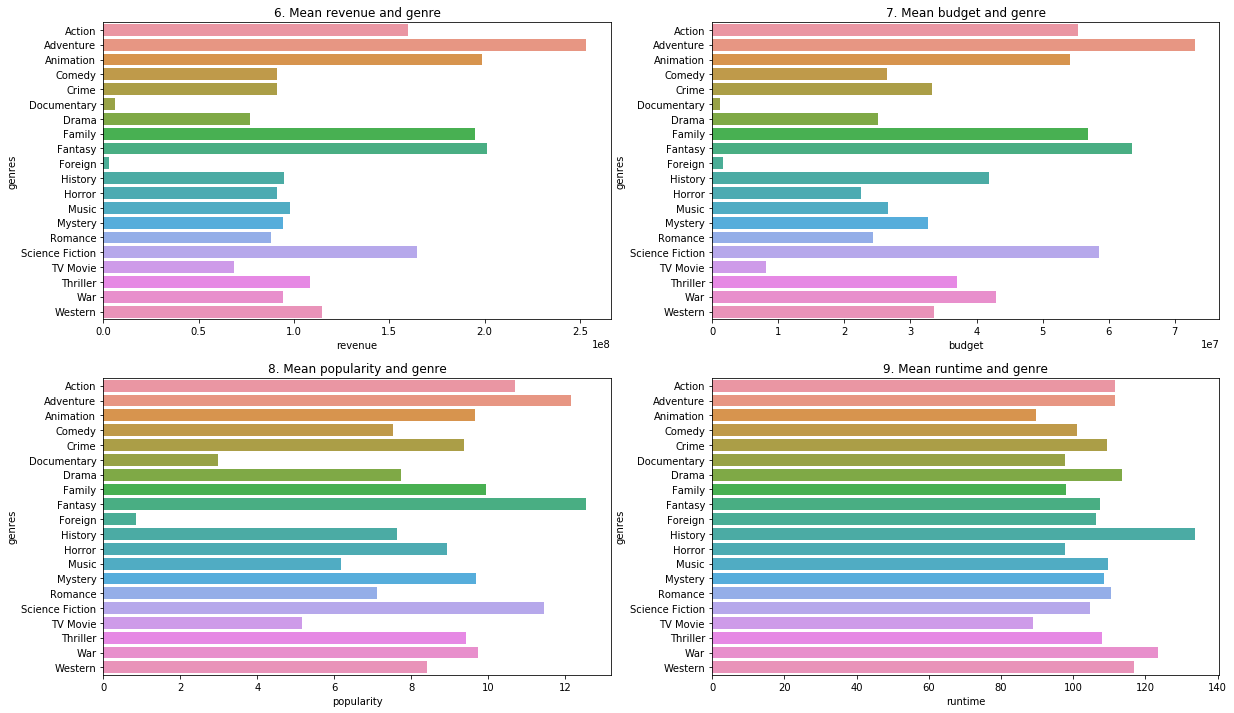

In [12]:
genres = dataset.explode("genres").copy()
genres = genres[genres.genres.notnull()].reset_index(drop=True)
genres["genres"]=genres["genres"].apply(lambda x : x['name'])
genres=genres.groupby(genres.genres).agg('mean')
plt.figure(figsize=(20,12))
plt.subplot(2,2,1)
plt.title("6. Mean revenue and genre")
sns.barplot(genres['revenue'],genres.index)

plt.subplot(2,2,2)
plt.title("7. Mean budget and genre")
sns.barplot(genres['budget'],genres.index)

plt.subplot(2,2,3)
plt.title("8. Mean popularity and genre")
sns.barplot(genres['popularity'],genres.index)

plt.subplot(2,2,4)
plt.title("9. Mean runtime and genre")
sns.barplot(genres['runtime'],genres.index)
plt.show()

Średnie największe przychody przynoszą filmy przygodowe, które posiadają również największe średnie budżety. 

Najmniejszy średni budżet posiadają filmy dokumentalne.

Średnie najmniejsze przychody przynoszą filmy dokumentalne.

Średnio największą popularnością cieszą się filmy fantasy a najmniejszą filmy dokumentalne.

Średnio najdłuższe są filmy historyczne a najkrótsze filmy telewizyjne i aniumacje.

In [13]:
genres

,id,budget,popularity,runtime,revenue
genres,,,,,
Action,1544.605938,5.532984e+07,10.686771,111.547908,1.600906e+08
Adventure,1466.562642,7.307119e+07,12.136292,111.708428,2.534838e+08
Animation,1509.113475,5.418770e+07,9.663479,89.829787,1.986236e+08
Comedy,1507.457198,2.647899e+07,7.514553,101.189873,9.123142e+07
Crime,1547.078891,3.325211e+07,9.372484,109.275053,9.123173e+07
Documentary,1363.701149,1.183166e+06,2.966898,97.816092,6.176284e+06
Drama,1513.161986,2.510553e+07,7.730080,113.603922,7.708735e+07
Family,1456.500000,5.687512e+07,9.926246,98.053846,1.949956e+08
Fantasy,1512.538793,6.345748e+07,12.545494,107.426724,2.010485e+08


Actors number:  38588


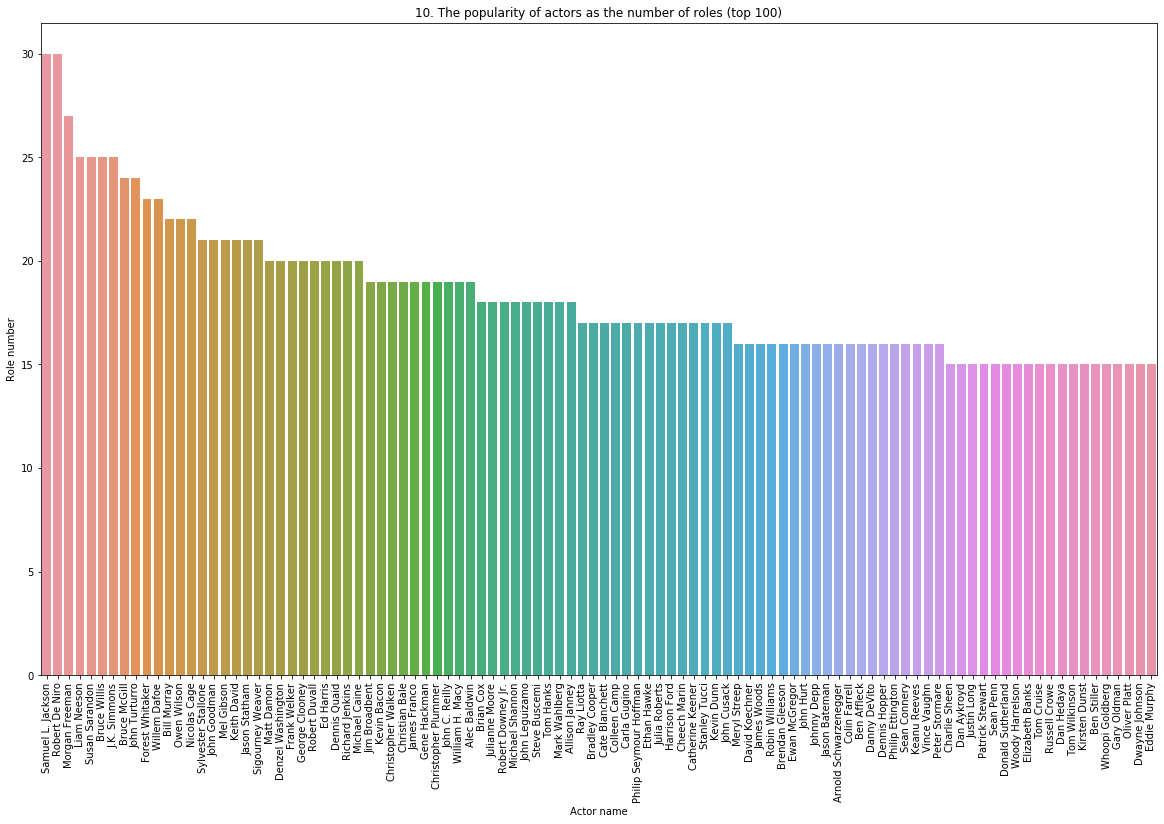

In [14]:
# popularity of an actor expressed as number of films
n = 100
actorMovieDataset = dataset_original[['id','cast']].copy()
actorMovieDataset['cast'] = actorMovieDataset['cast'].apply(lambda x: {} if pd.isna(x) else [x.get('name') for x in ast.literal_eval(x)])
actorMovieDataset = actorMovieDataset.explode('cast').reset_index(drop=True)
actorMovieDataset = actorMovieDataset.groupby(['cast']).size().reset_index(name='count').sort_values('count', ascending=False)
print("Actors number: ", actorMovieDataset.shape[0])

plt.figure(figsize=(20,12))
sns.barplot(actorMovieDataset['cast'].head(n), actorMovieDataset['count'].head(n))
plt.title("10. The popularity of actors as the number of roles (top {0})".format(n))
plt.xlabel("Actor name")
plt.ylabel("Role number")
plt.xticks(rotation=90)

plt.show()

Liczba aktorów w zbiorze danych wynosi 38588. Pokazanie na jednym wykresie liczby angaży dla wszystkich aktorów jest niewykonalne.

Najpopularniejszymi aktorami są Samuel L. Jackson oraz Robert De Niro. Obaj panowie zagrali w 30 filmach z naszego zbioru danych.

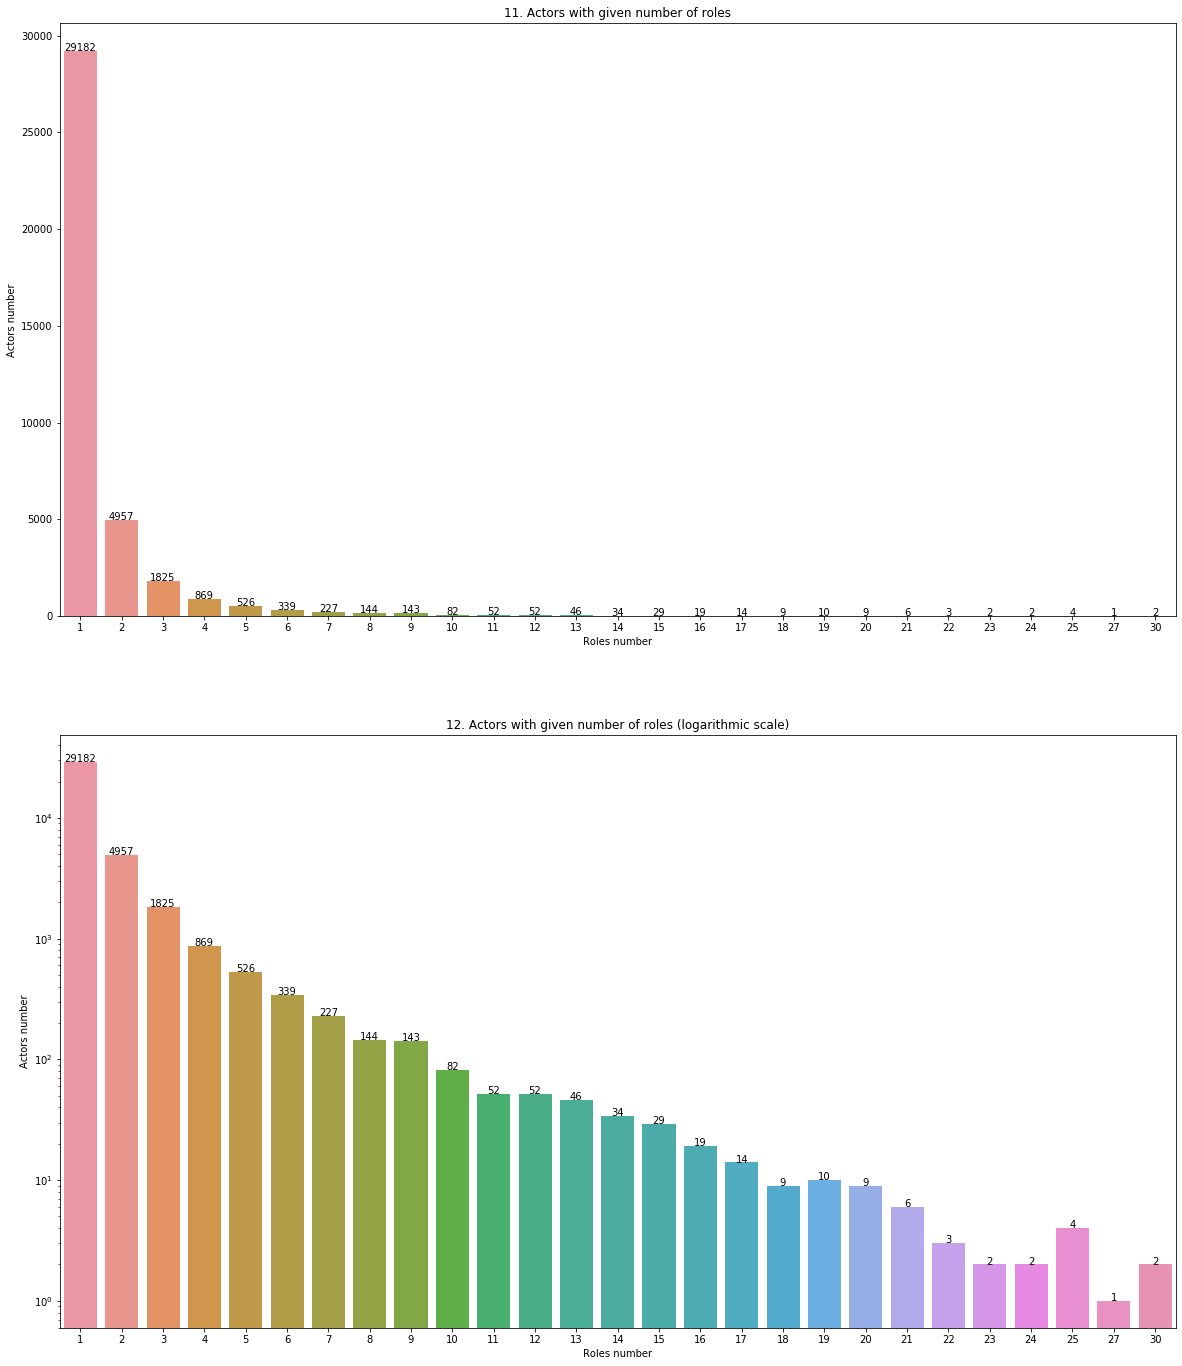

In [15]:
# number of actors with concrette role number
actorMovieDataset = dataset_original[['id','cast']].copy()
actorMovieDataset['cast'] = actorMovieDataset['cast'].apply(lambda x: {} if pd.isna(x) else [x.get('name') for x in ast.literal_eval(x)])
actorMovieDataset = actorMovieDataset.explode('cast').reset_index(drop=True)
actorMovieDataset = actorMovieDataset.groupby(['cast']).size().reset_index(name='count').sort_values('count', ascending=False)
actorMovieRolesDataset = actorMovieDataset.groupby(['count']).size().reset_index(name='actors_with_given_role_number')
x = actorMovieRolesDataset['count']
y = actorMovieRolesDataset['actors_with_given_role_number']

plt.figure(figsize=(20,12))
#plt.subplot(2,1,1)
snbp = sns.barplot(x='count',y='actors_with_given_role_number',data=actorMovieRolesDataset)
show_values_on_bars(snbp, "v", 0.5)
plt.title("11. Actors with given number of roles")
plt.xlabel("Roles number")
plt.ylabel("Actors number")
plt.show()


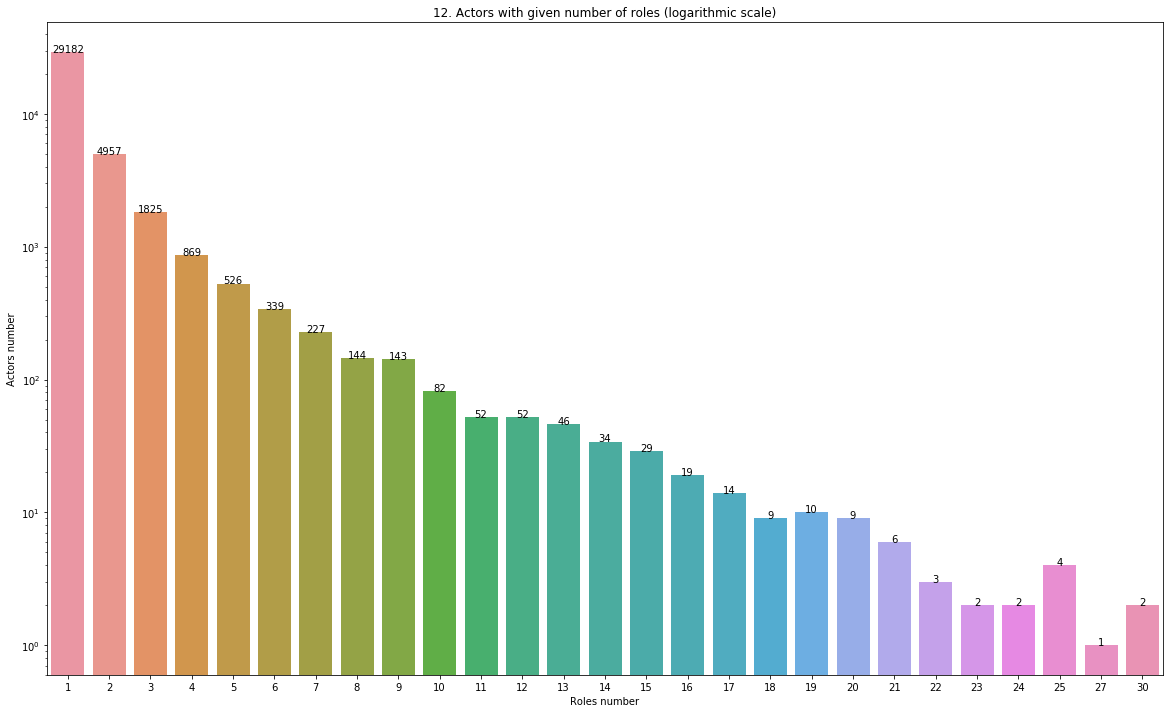

In [71]:
plt.figure(figsize=(20,12))
#plt.subplot(2,1,2)
snbp = sns.barplot(x='count',y='actors_with_given_role_number',data=actorMovieRolesDataset)
show_values_on_bars(snbp, "v", 0.5)
snbp.set_yscale('log')
plt.title("12. Actors with given number of roles (logarithmic scale)")
plt.xlabel("Roles number")
plt.ylabel("Actors number")

plt.show()

Dominujący są aktorzy, którzy zagrali w jednym filmie. Liczba aktorów, która zagrała tylko w jednym filmie stanowi ok. 75.6% wszystkich aktorów z zbiorze danych.

Wśród aktorów wysoką popularność przejawiającą się, jako duża liczba angaży, wykazuje wąskie grono osób. Tylko 376 aktorów zagrało w co najmniej 10 filmach, co stanowi zaledwie ok. 0.9%.

Liczba aktorów posiadających daną liczbę angaży maleje wykładniczo wraz z rosnącą liczbą zagranych ról.

In [16]:
oscars = pd.read_csv('./tmdb-box-office-prediction/the_oscar_award.csv')
oscars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10395 entries, 0 to 10394
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   year_film      10395 non-null  int64 
 1   year_ceremony  10395 non-null  int64 
 2   ceremony       10395 non-null  int64 
 3   category       10395 non-null  object
 4   name           10395 non-null  object
 5   film           10091 non-null  object
 6   winner         10395 non-null  bool  
dtypes: bool(1), int64(3), object(3)
memory usage: 497.5+ KB


In [17]:
oscars.head(10)

,year_film,year_ceremony,ceremony,category,name,film,winner
0,1927,1928,1,ACTOR,Richard Barthelmess,The Noose,False
1,1927,1928,1,ACTOR,Emil Jannings,The Last Command,True
2,1927,1928,1,ACTRESS,Louise Dresser,A Ship Comes In,False
3,1927,1928,1,ACTRESS,Janet Gaynor,7th Heaven,True
4,1927,1928,1,ACTRESS,Gloria Swanson,Sadie Thompson,False
5,1927,1928,1,ART DIRECTION,Rochus Gliese,Sunrise,False
6,1927,1928,1,ART DIRECTION,William Cameron Menzies,The Dove;,True
7,1927,1928,1,ART DIRECTION,Harry Oliver,7th Heaven,False
8,1927,1928,1,CINEMATOGRAPHY,George Barnes,The Devil Dancer;,False
9,1927,1928,1,CINEMATOGRAPHY,Charles Rosher,Sunrise,True


In [18]:
oscars_winners = oscars[oscars["winner"] == True].drop(columns=["winner", "year_film", "year_ceremony", "ceremony", "category", "name"])
oscars_winners = oscars_winners[oscars_winners["film"].notnull()]

dataset_lc = dataset.copy()
oscars_winners_lc = oscars_winners.copy()
dataset_lc['title'] = dataset_lc['title'].str.lower()
oscars_winners_lc['film'] = oscars_winners_lc['film'].str.lower()

oscar_movies = pd.merge(left=dataset_lc, right=oscars_winners_lc, left_on='title', right_on='film').drop_duplicates(subset="id")
oscar_movies = oscar_movies.drop(columns=["film", "id"])
oscar_movies

,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,...,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue
0,{},3563750,"[{'id': 18, 'name': 'Drama'}]",http://sonyclassics.com/whiplash/,tt2582802,en,Whiplash,"Under the direction of a ruthless instructor, ...",64.299990,/lIv1QinFqz4dlp5U4lQ6HaiskOZ.jpg,...,2014-10-10,105.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The road to greatness can take you to the edge.,whiplash,"[{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...","[{'cast_id': 5, 'character': 'Andrew Neimann',...","[{'credit_id': '54d5356ec3a3683ba0000039', 'de...",14138371
3,"[{'id': 1575, 'name': 'Rocky Collection', 'pos...",4493093,"[{'id': 18, 'name': 'Drama'}]",NaN,tt0075148,en,Rocky,"When world heavyweight boxing champion, Apollo...",14.774066,/i5xiwdSsrecBvO7mIfAJixeEDSg.jpg,...,1976-11-21,119.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,His whole life was a million-to-one shot.,rocky,"[{'id': 240, 'name': 'underdog'}, {'id': 276, ...","[{'cast_id': 16, 'character': 'Rocky Balboa', ...","[{'credit_id': '579948e9c3a36874e9007b0b', 'de...",526748435
6,{},23018337,"[{'id': 18, 'name': 'Drama'}]",http://www.dreamworks.com/ab/,tt0169547,en,American Beauty,"Lester Burnham, a depressed suburban father in...",20.726578,/or1MP8BZIAjqWYxPdPX724ydKar.jpg,...,1999-09-15,122.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Look closer.,american beauty,"[{'id': 255, 'name': 'male nudity'}, {'id': 29...","[{'cast_id': 6, 'character': 'Lester Burnham',...","[{'credit_id': '52fe420ec3a36847f80007c5', 'de...",546757023
11,{},22963203,"[{'id': 80, 'name': 'Crime'}, {'id': 18, 'name...",NaN,tt0061512,en,Cool Hand Luke,When petty criminal Luke Jackson is sentenced ...,9.718713,/vDwphkloD7ToaDpKASAXGgHOclN.jpg,...,1967-06-22,126.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,What we've got here is failure to communicate.,cool hand luke,"[{'id': 378, 'name': 'prison'}, {'id': 526, 'n...","[{'cast_id': 13, 'character': 'Luke Jackson', ...","[{'credit_id': '52fe428ac3a36847f8026d8d', 'de...",124137341
12,{},47460342,"[{'id': 80, 'name': 'Crime'}, {'id': 18, 'name...",http://thehatefuleight.com/,tt3460252,en,The Hateful Eight,Bounty hunters seek shelter from a raging bliz...,20.328822,/fqe8JxDNO8B8QfOGTdjh6sPCdSC.jpg,...,2015-12-25,167.0,"[{'iso_639_1': 'es', 'name': 'Español'}, {'iso...",Released,No one comes up here without a damn good reason.,the hateful eight,"[{'id': 801, 'name': 'bounty hunter'}, {'id': ...","[{'cast_id': 22, 'character': 'Major Marquis W...","[{'credit_id': '538aa95ec3a368714e0005b3', 'de...",168009738
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
506,{},8354803,"[{'id': 12, 'name': 'Adventure'}, {'id': 35, '...",NaN,tt0057590,en,Tom Jones,Tom loves Sophie and Sophie loves Tom. But Tom...,3.315827,/7pn0MuzLX0tkBnNymdJtF52QQZV.jpg,...,1963-10-06,128.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Tom Jones! . . . loves and loves and loves and...,tom jones,"[{'id': 5626, 'name': 'from rags to riches'}, ...","[{'cast_id': 6, 'character': 'Tom Jones', 'cre...","[{'credit_id': '52fe4421c3a36847f8084025', 'de...",314140627
510,{},67924584,"[{'id': 18, 'name': 'Drama'}, {'id': 10402, 'n...",http://www.lesmiserablesfilm.com,tt1707386,en,Les Misérables,An adaptation of the successful stage musical ...,13.524080,/qEsrAHoxj746FRb7OLGYjrx1AI3.jpg,...,2012-12-18,157.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Fight. Dream. Hope. Love.,les misérables,"[{'id': 254, 'name': 'france'}, {'id': 642, 'n...",{},{},491963031
513,"[{'id': 387219, 'name': 'The Hustler Collectio...",17100802,"[{'id': 18, 'name': 'Drama'}]",NaN,tt0054997,en,The Hustler,Fast Eddie Felson is a small-time pool hustler...,9.333533,/u38NLUtWarEbv2gZGOnHhf6akWC.jpg,...,1961-09-25,134.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,They called him Fast Eddie. He was a wi

In [19]:
dataset = oscar_movies

In [20]:
print("Oldest: ", dataset["release_date"].min())
print("Newest: ", dataset["release_date"].max())

Oldest:  1924-03-18 00:00:00
Newest:  2017-03-24 00:00:00


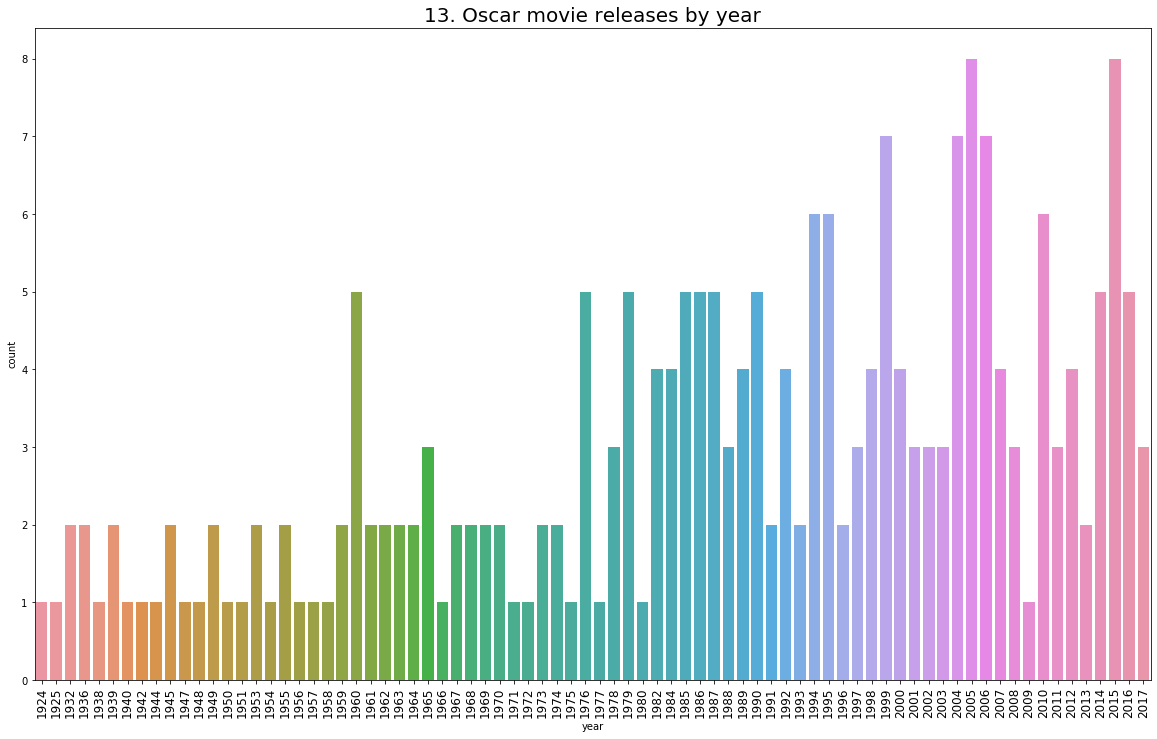

In [21]:
plt.figure(figsize=(20,12))
sns.countplot(dataset['release_date'].dt.year.sort_values())
plt.title("13. Oscar movie releases by year",fontsize=20)
plt.xticks(fontsize=12,rotation=90)
plt.xlabel("year")
plt.show()

Rozkład filmów oscarowych jest podobny we wszystkich latach. Nasz oryginalny zbiór nie zawiera wszystkich filmów oscarowych

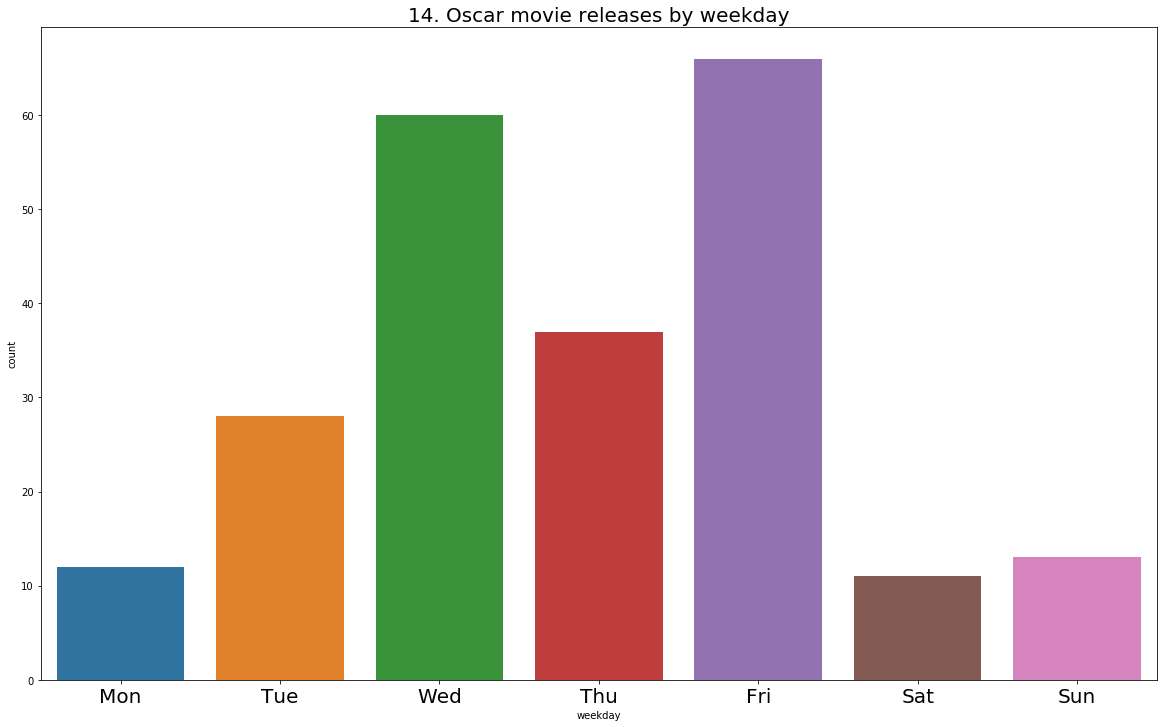

In [22]:
plt.figure(figsize=(20,12))
sns.countplot(dataset['release_date'].dt.weekday.sort_values())
plt.title("14. Oscar movie releases by weekday",fontsize=20)
loc, _ = plt.xticks()
loc, labels = loc, ["Mon","Tue","Wed","Thu","Fri","Sat","Sun"]
plt.xticks(loc, labels,fontsize=20)
plt.xlabel("weekday")
plt.show()

Najwięcej filmów oscarowych wydaje się w środę oraz piątek, najmniej w sobotę, poniedziałek i niedzielę

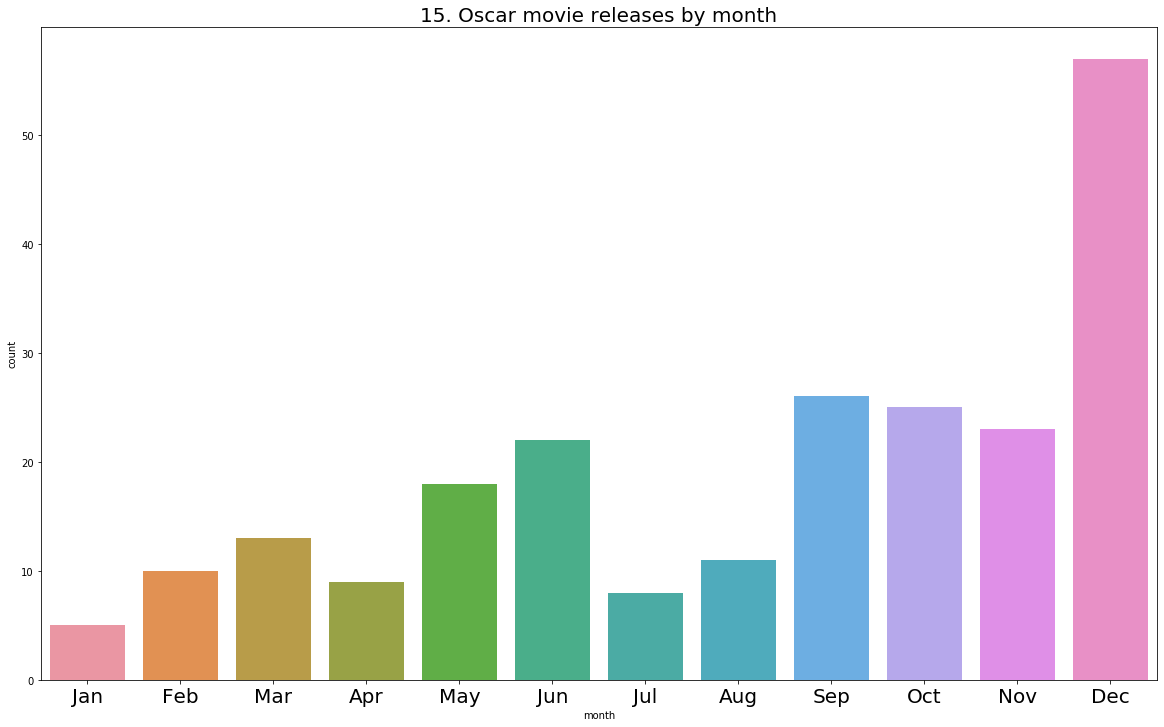

In [23]:
plt.figure(figsize=(20,12))
sns.countplot(dataset['release_date'].dt.month.sort_values())
plt.title("15. Oscar movie releases by month",fontsize=20)
loc, _ = plt.xticks()
loc, labels = loc, ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
plt.xticks(loc, labels,fontsize=20)
plt.xlabel("month")
plt.show()

Najwięcej filmów oscarowych wydanych zostało w grudniu a najmniej w styczniu i lipcu

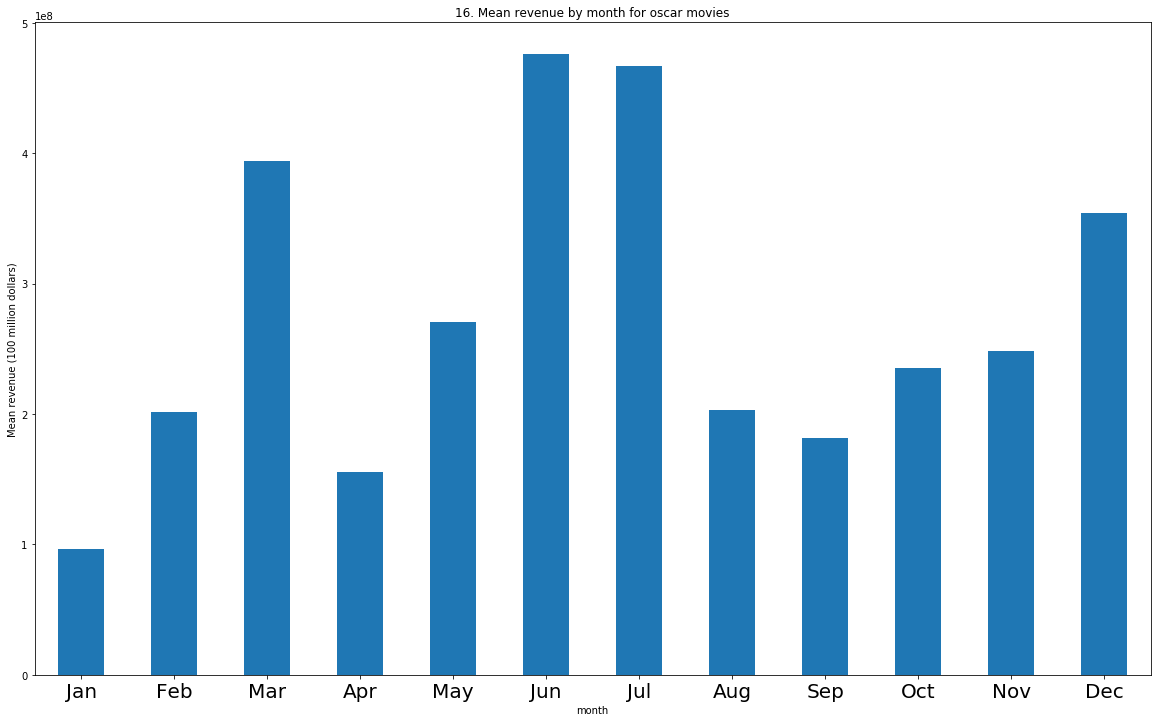

In [27]:
plt.figure(figsize=(20,12))
dataset.groupby(dataset["release_date"].dt.month).agg('mean')['revenue'].plot(kind='bar',rot=0)
plt.ylabel('Mean revenue (100 million dollars)')
plt.title("16. Mean revenue by month for oscar movies")
loc, _ = plt.xticks()
loc, labels = loc, ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
plt.xticks(loc, labels,fontsize=20)
plt.xlabel("month")
plt.show()

Dla filmów oscarowych tak samo średnio najwięcej przychodów przynoszą filmy wydane w czerwcu i lipcu a najmniej filmy wydane w styczniu

In [ ]:
plt.figure(figsize=(20,12))
genre=dataset['genres'].apply(lambda x: [i['name'] for i in x] if x != {} else [])
count=Counter([i for j in genre for i in j]).most_common(20)
sns.barplot([val[1] for val in count],[val[0] for val in count])
plt.title("17. Movies by category")
plt.xlabel("Movie count")
plt.ylabel("Category")
plt.show()

Najwięcej nagrodzonych zostało dramatów a najmniej filmów dokumentalnych

In [ ]:
genres = dataset.explode("genres").reset_index(drop=True)
genres = genres[genres.genres.notnull()]
genres['genres']=genres.genres.apply(lambda x :x['name'])
genres=genres.groupby(genres.genres).agg('mean')
plt.figure(figsize=(20,12))
plt.subplot(2,2,1)
plt.title("18. Mean revenue and genre")
sns.barplot(genres['revenue'],genres.index)

plt.subplot(2,2,2)
plt.title("19. Mean budget and genre")
sns.barplot(genres['budget'],genres.index)

plt.subplot(2,2,3)
plt.title("20. Mean popularity and genre")
sns.barplot(genres['popularity'],genres.index)

plt.subplot(2,2,4)
plt.title("21. Mean runtime and genre")
sns.barplot(genres['runtime'],genres.index)
plt.show()

Średnie największe przychody z filmów oscarowych przynoszą horrory przy stosunkowo niskich budżetach. 

Średnie największe budżety posiadają filmy animowane. 

Średnie najmniejsze przychody przynoszą filmy dokumentalne, posiadają one również średnio najmniejszy budżet.

Średnio największą popularnością cieszą się filmy fantasy a najmniejszą filmy dokumentalne.

Średnio najdłuższe są horrory a najkrótsze filmy dokumentalne.

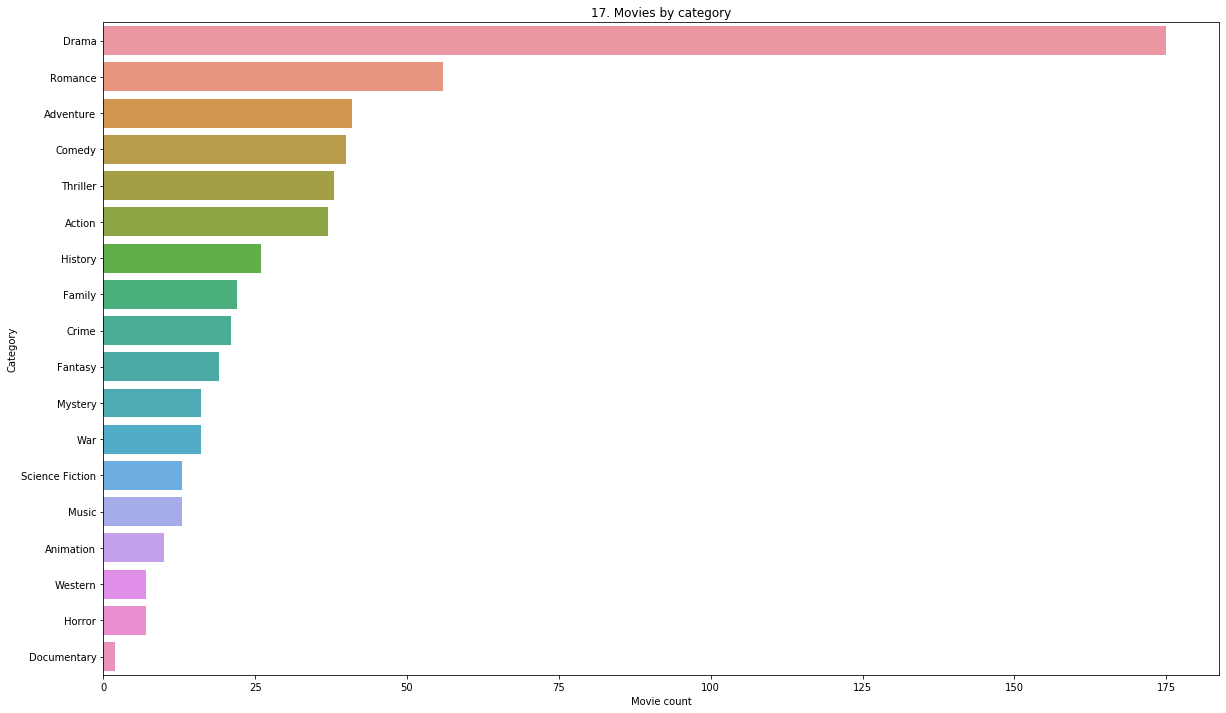

In [25]:
Średnie największe przychody z filmów oscarowych przynoszą horrory przy stosunkowo niskich budżetach. 

Średnie największe budżety posiadają filmy animowane. 

Średnie najmniejsze przychody przynoszą filmy dokumentalne, posiadają one również średnio najmniejszy budżet.

Średnio największą popularnością cieszą się filmy fantasy a najmniejszą filmy dokumentalne.

Średnio najdłuższe są horrory a najkrótsze filmy dokumentalne.

Najwięcej nagrodzonych zostało dramatów a najmniej filmów dokumentalnych

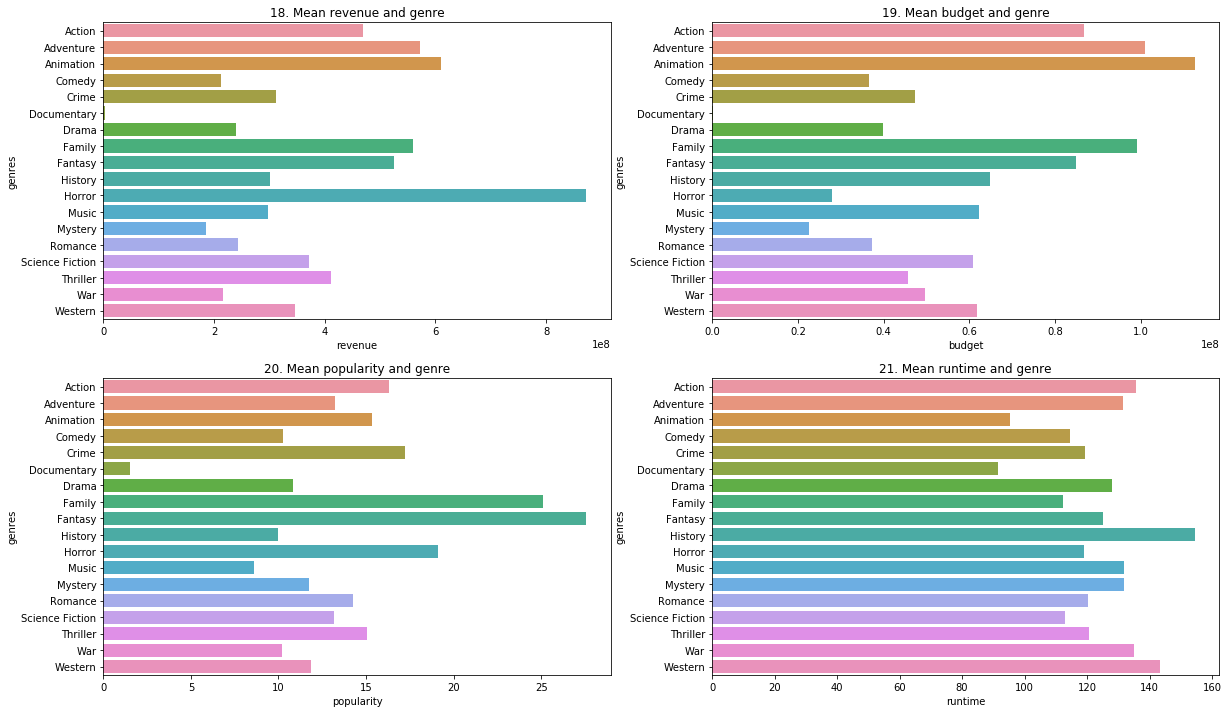

In [26]:
genres = dataset.explode("genres").reset_index(drop=True)
genres = genres[genres.genres.notnull()]
genres['genres']=genres.genres.apply(lambda x :x['name'])
genres=genres.groupby(genres.genres).agg('mean')
plt.figure(figsize=(20,12))
plt.subplot(2,2,1)
plt.title("18. Mean revenue and genre")
sns.barplot(genres['revenue'],genres.index)

plt.subplot(2,2,2)
plt.title("19. Mean budget and genre")
sns.barplot(genres['budget'],genres.index)

plt.subplot(2,2,3)
plt.title("20. Mean popularity and genre")
sns.barplot(genres['popularity'],genres.index)

plt.subplot(2,2,4)
plt.title("21. Mean runtime and genre")
sns.barplot(genres['runtime'],genres.index)
plt.show()

Średnie największe przychody z filmów oscarowych przynoszą horrory przy stosunkowo niskich budżetach. 

Średnie największe budżety posiadają filmy animowane. 

Średnie najmniejsze przychody przynoszą filmy dokumentalne, posiadają one również średnio najmniejszy budżet.

Średnio największą popularnością cieszą się filmy fantasy a najmniejszą filmy dokumentalne.

Średnio najdłuższe są horrory a najkrótsze filmy dokumentalne.